## Este código contiene un callback personalizado que combina las funcionalidades de "Early Stopping", "Reduce Learning Rate on Plateau" y "Model Checkpoint". A continuación, se detallan los parámetros de entrada:

In [9]:
# TensorFlow y Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K, layers, optimizers, metrics, regularizers, preprocessing, models
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from keras.preprocessing.image import ImageDataGenerator

# Data handle
import numpy as np
import pandas as pd
import shutil, time, cv2, os
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML
sns.set_style('darkgrid')

### IMAGES AND CSV FILE: READ AND IMPORT

(450, 600, 3)

              image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310.jpg  1.0  0.0  0.0    0.0  0.0  0.0   0.0
10015
Index(['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'], dtype='object')

Transformation
              image label
0  ISIC_0024306.jpg    NV
1  ISIC_0024307.jpg    NV
2  ISIC_0024308.jpg    NV
3  ISIC_0024309.jpg    NV
4  ISIC_0024310.jpg   MEL



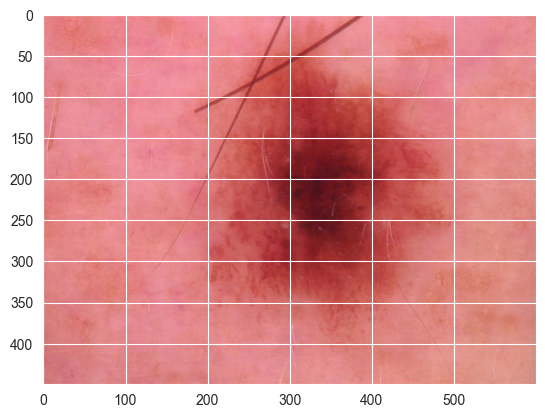

In [11]:
# IMPORT IMAGES AND SHAPES

# Image file rute
fpath = r'./input/ham1000-segmentation-and-classification/images/ISIC_0024306.jpg'
img = plt.imread(fpath)

# Print
print(img.shape) #print the image shape
plt.imshow(img) # print the image with matplotlib
print()

# READ THE CSV FILE

# Read the CSV into a DataFrame using Pandas
df = pd.read_csv(r'./input/ham1000-segmentation-and-classification/GroundTruth.csv')
df['image'] = df['image'] + '.jpg'  # ".jpg" extension added to the 'image' column values

# Print
print(df.head()) # the first five rows
print(len(df)) # number of rows
print(df.columns) # number of columns
print()


# TRANSFORMATION The main reason to perform this transformation is to overcome the limitations or problems encountered when using the 
# `ImageDataGenerator.flow_from_dataframe` of `Keras`. By having the labels in a categorical form instead of `one hot encoding`, 
# it is easier and more straightforward to use the function with class_mode='categorical`.

# Define the labels present in the DataFrame in "one hot encoding" format.
labels=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
label_list=[]

for i in range (len(df)):
    row= list(df.iloc[i])      # Fetch the current row.
    del row[0]                 # Remove the first element from the row.
    index=np.argmax(row)       # Find the index of the element having the maximum value (1 in this case, due to "one hot encoding").
    label=labels[index]        # Identify the corresponding categorical label.
    label_list.append(label)

# Add the list of categorical labels to the DataFrame, drop the original "one hot encoding" columns from the DataFrame.
df['label']= label_list
df=df.drop(labels, axis=1)

print('Transformation')
print (df.head())
print()


### Train, Test and Valid Dataframes

In [12]:
# Define data split percentages.
train_split = 0.95
valid_split = 0.025 

# Calculate the size of the dummy split to later obtain the test set.
# This is done because the total percentage reserved for testing is 1 - train_split - valid_split.
dummy_split = valid_split / (1 - train_split)

# Split the DataFrame into training sets and a dummy set.
# Use shuffle to randomly mix the entries and random_state for reproducibility.
train_df, dummy_df = train_test_split(df, train_size=train_split, shuffle=True, random_state=123)

# Split the dummy set into validation and test sets.
valid_df, test_df = train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)

# Print the length of each set (training, testing, and validation).
print('train_df length:', len(train_df), ' test_df length:', len(test_df), ' valid_df length:', len(valid_df))

# Optional: Display top rows of the training set and label distribution.
print(train_df.head())
print(train_df['label'].value_counts())


train_df length: 9514  test_df length: 251  valid_df length: 250
                 image label
3231  ISIC_0027537.jpg    NV
7927  ISIC_0032233.jpg    NV
6141  ISIC_0030447.jpg    NV
5967  ISIC_0030273.jpg    NV
7336  ISIC_0031642.jpg   MEL
NV       6384
MEL      1053
BKL      1035
BCC       488
AKIEC     309
VASC      138
DF        107
Name: label, dtype: int64


### dataset is highly out of balance limit maximum samples per class to 300 samples to help balance it

In [13]:
# Print the original number of unique classes
print('Original number of classes:', len(df['label'].unique()))

# Set a maximum limit of samples per class
size = 300
samples = []
group = df.groupby('label')


# Sample each class based on the desired size
for label in df['label'].unique():
    Lgroup = group.get_group(label)
    count = int(Lgroup['label'].value_counts())
    
    if count >= size:
        sample = Lgroup.sample(size, axis=0)
    else:
        sample = Lgroup.sample(frac=1, axis=0)
    
    samples.append(sample)

train_df = pd.concat(samples, axis=0).reset_index(drop=True)
print('Final number of classes:', len(train_df['label'].unique()))
print(train_df['label'].value_counts())

Original number of classes: 7
Final number of classes: 7
NV       300
MEL      300
BKL      300
AKIEC    300
BCC      300
VASC     142
DF       115
Name: label, dtype: int64


### create train, test, valid  generators

In [14]:
# Define the directory where images are located.
sdir = r'./input/ham1000-segmentation-and-classification/images'

# Define the shape of the input images.
img_shape = (224, 224, 3)

# Define the batch size for the training data.
batch_size = 40

# Determine the appropriate batch size for the test data.
# The goal is to find a batch size that:
# 1. Divides the total test samples without a remainder.
# 2. Is as large as possible but does not exceed 80.
length = len(test_df)
test_batch_size = sorted([int(length/n) for n in range(1, length+1) if length % n ==0 and length/n <= 80], reverse=True)[0]

# Calculate the number of steps for the test generator based on the batch size.
test_steps = int(length/test_batch_size)
print('Test batch size:', test_batch_size, '  Test steps:', test_steps)

# Initialize an image data generator. 
# This facilitates loading, transforming, and batching the images.
gen = ImageDataGenerator()

# Create a data generator for training data. 
# This generator loads images from the dataframe, applies necessary transformations, and returns batches of images.
train_gen = gen.flow_from_dataframe(train_df, sdir, x_col='image', y_col='label', target_size=img_shape[:2], class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

# Similarly, create data generators for test and validation datasets.
test_gen = gen.flow_from_dataframe(test_df, sdir, x_col='image', y_col='label', target_size=img_shape[:2], class_mode='categorical',
                                   color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen = gen.flow_from_dataframe(valid_df, sdir, x_col='image', y_col='label', target_size=img_shape[:2], class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

# Extract the list of classes from the training generator.
classes = list(train_gen.class_indices.keys())

# Calculate the number of unique classes.
class_count = len(classes)

# Determine the number of training steps per epoch.
# This ensures each sample is seen once per epoch.
train_steps = int(len(train_gen.labels)/batch_size)


Test batch size: 1   Test steps: 251
Found 1757 validated image filenames belonging to 7 classes.
Found 251 validated image filenames belonging to 7 classes.
Found 250 validated image filenames belonging to 7 classes.


### train data is still misblanced but not as bad use class_weight  to help with this

In [15]:
class_weight = {}
train_dict = train_gen.class_indices
labels = train_gen.labels
count_array = np.zeros((len(train_dict)))

for value in train_dict.values():
    for label in labels:
        if label == value:
            count_array[value] += 1

max_samples = np.max(count_array)
max_index = np.argmax(count_array)
max_class = list(train_dict.keys())[max_index]

print('Class', max_class, 'with', max_samples, 'samples has the largest sample size')

for i in range(len(train_dict)):
    class_weight[i] = max_samples / count_array[i]
    print('Class:', list(train_dict.keys())[i], 'Samples:', count_array[i], 'Weight:', class_weight[i])



Class AKIEC with 300.0 samples has the largest sample size
Class: AKIEC Samples: 300.0 Weight: 1.0
Class: BCC Samples: 300.0 Weight: 1.0
Class: BKL Samples: 300.0 Weight: 1.0
Class: DF Samples: 115.0 Weight: 2.608695652173913
Class: MEL Samples: 300.0 Weight: 1.0
Class: NV Samples: 300.0 Weight: 1.0
Class: VASC Samples: 142.0 Weight: 2.112676056338028


### create function to show some image examples

In [16]:
def show_image_samples(gen):
    """
    Display a sample batch of images from the provided generator.
    
    Parameters:
    - gen: Data generator that yields batches of images and labels.
    """
    
    classes = list(gen.class_indices.keys()) # Extract class names from the generator     
    images, labels = next(gen) # Get a sample batch from the generator      
    num_images = min(len(labels), 25) # Determine number of images to display (max of 25)       
    grid_size = int(num_images**0.5) # Calculate number of rows and columns for the grid    
    plt.figure(figsize=(20, 20))
    
    for i in range(num_images):
        plt.subplot(grid_size, grid_size, i + 1)
        
        # If the image isn't already scaled between 0 and 1, scale it
        if images[i].max() > 1:
            image = images[i] / 255 
        else:
            image = images[i]
        
        plt.imshow(image)
        
        # Extract class name using the label
        index = np.argmax(labels[i])
        class_name = classes[index]
        
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    
    plt.show()



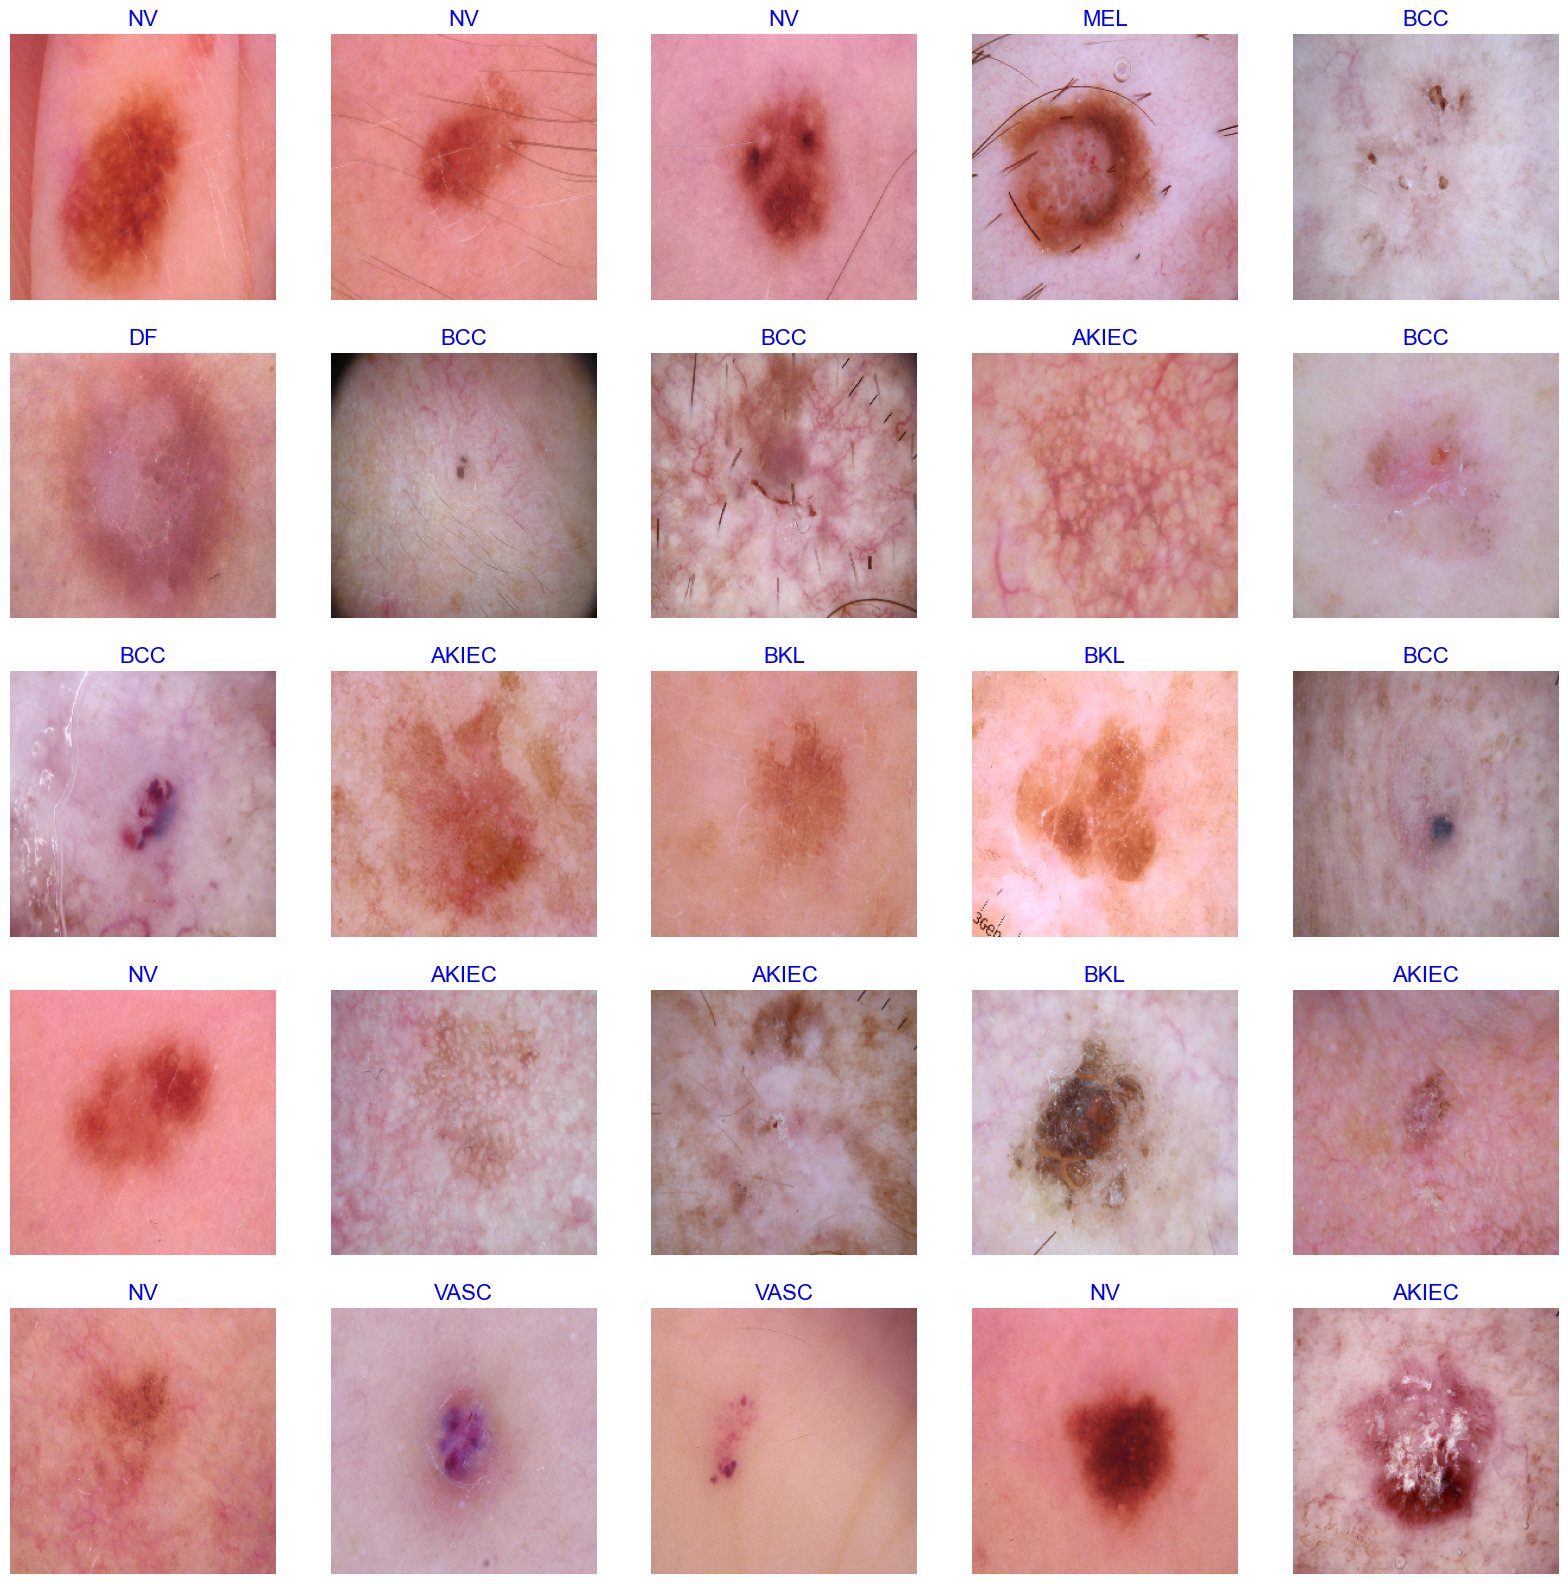

In [17]:
show_image_samples(train_gen)

### define function to print text in RGB foreground and background colors

In [18]:
def print_in_color(txt_msg: str, fore_tuple: tuple[int, int, int], back_tuple: tuple[int, int, int]) -> None:
    """Prints the text_msg in the foreground color specified by fore_tuple with the background specified by back_tuple.
    
    Parameters:
    - txt_msg (str): the text to print
    - fore_tuple (tuple[int, int, int]): foreground color tuple (r,g,b)
    - back_tuple (tuple[int, int, int]): background color tuple (r,g,b)
    """
    
    # Unpack tuple values
    rf, gf, bf = fore_tuple
    rb, gb, bb = back_tuple
    
    # Create the format string
    mat = f'\33[38;2;{rf};{gf};{bf};48;2;{rb};{gb};{bb}m'
    
    # Print the colored text and then reset to default colors
    print(f"{mat}{txt_msg}\33[0m", flush=True)


### create the model

In [19]:
model_name='EfficientNetB1' # Se establece el nombre del modelo

# Carga del modelo EfficientNetB1 preentrenado con los pesos de imagenet y sin incluir la capa superior. Se configura con una forma específica de imagen y pooling máximo.
base_model=tf.keras.applications.EfficientNetB1(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

# Obtiene la salida del modelo base
x=base_model.output

# Aplica una capa de normalización por lotes para regularizar y acelerar el entrenamiento
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)

# Agrega una capa densa con 256 neuronas, activación ReLU y regularización L1 y L2
x = Dense(256, kernel_regularizer=regularizers.l2(l=0.016), 
          activity_regularizer=regularizers.l1(0.006), 
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)

# Aplica dropout para prevenir el sobreajuste. Desactiva el 45% de las neuronas de la capa anterior durante el entrenamiento.
x=Dropout(rate=.45, seed=123)(x)

# Capa de salida densa con una cantidad de neuronas igual al número de clases y activación softmax para clasificación
output=Dense(class_count, activation='softmax')(x)

# Construye el modelo final conectando la entrada del modelo base con la salida definida anteriormente
model=Model(inputs=base_model.input, outputs=output)

# Compila el modelo con el optimizador Adamax, pérdida de entropía cruzada categórica y métrica de precisión
model.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy'])



### create a subclass of callbacks to control learning rate and print training results for each epoch

In [20]:
def print_in_color(txt_msg, fore_tupple, back_tupple,):
    # Placeholder. I'm assuming the original code had a function to print in color.
    # If you can provide this function, I will integrate it.
    print(txt_msg)

class LRA(keras.callbacks.Callback):
    
    def __init__(self, model, patience, stop_patience, threshold, factor, dwell, model_name, freeze, batches, initial_epoch):
        super(LRA, self).__init__()
        
        # Model, Initial Epoch and Batch Information
        self.model = model
        self.initial_epoch = initial_epoch
        self.batches = batches
        
        # Learning Rate Adjustment Parameters
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.dwell = dwell
        self.lr = float(tf.keras.backend.get_value(model.optimizer.lr))
        
        # Tracking Metrics and Counts
        self.highest_tracc = 0.0
        self.lowest_vloss = np.inf
        self.count = 0
        self.stop_count = 0
        
        # Store Initial Best Weights
        self.best_weights = self.model.get_weights()
        
        # Starting Message based on Model Training Status
        msg = f'Starting training using base model {model_name} {"with weights frozen to imagenet weights" if freeze else "training all layers"} initializing LRA callback'
        print_in_color(msg, (244, 252, 3), (55,65,80))

    def on_train_begin(self, logs=None):
        """Displays formatted header at the start of training."""
        header = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', 'Duration', 'Batch')
        print_in_color(header, (244,252,3), (55,65,80))

    def on_train_batch_begin(self, batch, logs=None):
        """Displays the current batch number during training."""
        msg = '{0:83s}{1:4s} of {2:5s}'.format(' ', str(batch), str(self.batches))
        print(msg, '\r', end='')

    def on_epoch_begin(self, epoch, logs=None):
        """Records the start time of the epoch."""
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        """Adjusts learning rate and stops training if needed."""
        duration = time.time() - self.start_time
        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        v_loss, acc, v_acc, loss = logs.get('val_loss'), logs.get('accuracy'), logs.get('val_accuracy'), logs.get('loss')
        
        if acc < self.threshold:
            monitor = 'accuracy'
            color, self.lr = self._adjust_learning_rate_on_metric(acc, self.highest_tracc, lr, v_loss)
        else:
            monitor = 'val_loss'
            color, self.lr = self._adjust_learning_rate_on_metric(v_loss, self.lowest_vloss, lr, v_loss, improve='decrease')
        
        msg = f'{epoch+1:^3}/{LRA.tepochs:4} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{lr:^9.5f}{self.lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
        print_in_color(msg, color, (55,65,80))

        if self.stop_count > self.stop_patience:
            self._halt_training(epoch)

    def _adjust_learning_rate_on_metric(self, metric, best_metric, lr, v_loss, improve='increase'):
        """Helper function to adjust learning rate based on metric improvement."""
        if (improve == 'increase' and metric > best_metric) or (improve == 'decrease' and metric < best_metric):
            best_metric = metric
            self.best_weights = self.model.get_weights()
            self.count = 0
            self.stop_count = 0
            color = (0, 255, 0)
        else:
            if self.count >= self.patience:
                color = (245, 170, 66)
                lr *= self.factor
                self.count = 0
                self.stop_count += 1
                tf.keras.backend.set_value(self.model.optimizer.lr, lr)
                if self.dwell:
                    self.model.set_weights(self.best_weights)
        return color, lr

    def _halt_training(self, epoch):
        """Helper function to halt training."""
        msg = f'Training halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate without improvement'
        print_in_color(msg, (0, 255, 0), (55,65,80))
        self.model.stop_training = True

### Instantiate the callback and train the model

In [16]:
epochs =40
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
batches=train_steps
callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, model_name=model_name, freeze=freeze, batches=batches,initial_epoch=0 )]
LRA.tepochs=epochs  # used to determine value of last epoch for printing
history=model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0, class_weight=class_weight)

Starting training using base model EfficientNetB5 training all layers initializing LRA callback
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration Batch  
 1 /  40   9.477   41.548   8.84710  38.400   0.00100  0.00100  accuracy   627.92  43   of 43    
 2 /  40   7.775   67.445   7.35901  68.000   0.00100  0.00100  accuracy   574.01  43   of 43    
 3 /  40   6.908   78.486   6.71986  74.400   0.00100  0.00100  accuracy   500.14  43   of 43    
 4 /  40   6.192   88.105   6.31012  73.600   0.00100  0.00100  accuracy  2612.61  43   of 43    
 5 /  40   5.633   91.577   5.79418  79.200   0.00100  0.00100  val_loss   534.74  43   of 43    
 6 /  40   5.156   93.455   5.46288  77.600   0.00100  0.00100  val_loss   519.38  43   of 43    
 7 /  40   4.694   96.244   5.06146  78.800   0.00100  0.00100  val_loss  1345.07  43   of 43    
 8 /  40   4.298   96.699   4.72960  76.000   0.00100  0.00100  val_loss   555.55  43   of 43    
 9 /  40   3.926   98.008   4.

### define function to plot the training data

In [4]:
def tr_plot(tr_data, start_epoch):
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    
    epochs = list(range(start_epoch, start_epoch + len(tacc)))

    index_loss = np.argmin(vloss)
    val_lowest = vloss[index_loss]

    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]

    plt.style.use('fivethirtyeight')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

    # Plotting Loss
    axes[0].plot(epochs, tloss, 'r', label='Training loss')
    axes[0].plot(epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(epochs[index_loss], val_lowest, s=150, c='blue', label=f'best epoch= {epochs[index_loss]}')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Plotting Accuracy
    axes[1].plot(epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(epochs[index_acc], acc_highest, s=150, c='blue', label=f'best epoch= {epochs[index_acc]}')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout()
    plt.show()


### define function to generate the confusion matrix and classification report

In [6]:
def save_class_dictionary_as_text(class_dict, save_dir, subject):
    """
    Save the class dictionary as a text file.
    """
    classes = list(class_dict.values())
    dict_as_text = str(class_dict)
    dict_name = f"{subject}-{len(classes)}.txt"
    dict_path = os.path.join(save_dir, dict_name)
    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)

def print_errors(error_list, pred_class, true_class, prob_list, print_code):
    """
    Print the misclassification errors.
    """
    errors = len(error_list)
    if errors == 0:
        msg = 'With accuracy of 100% there are no errors to print'
        print_in_color(msg, (0, 255, 0), (55, 65, 80))
        return
    
    r = min(print_code, errors)
    header_msg = '{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class', 'True Class', 'Probability')
    print_in_color(header_msg, (0, 255, 0), (55, 65, 80))
    
    for i in range(r):
        path_parts = os.path.split(error_list[i])
        parent_folder = os.path.split(path_parts[0])[1]
        fname = f"{parent_folder}/{path_parts[1]}"
        msg = '{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i], true_class[i], ' ', prob_list[i])
        print_in_color(msg, (255, 255, 255), (55, 65, 60))

def plot_error_barchart(error_indices, class_dict):
    """
    Plot a bar chart showing the number of errors by class.
    """
    plot_bar = []
    plot_class = []
    
    for key, value in class_dict.items():
        count = error_indices.count(key)
        if count != 0:
            plot_bar.append(count)
            plot_class.append(value)
            
    plt.figure(figsize=(10, len(plot_class)/3))
    plt.style.use('fivethirtyeight')
    plt.barh(plot_class, plot_bar)
    plt.title('Errors by Class on Test Set')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    """
    Plot a heatmap representing the confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(max(8, len(classes)*0.5), max(8, len(classes)*0.5)))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(len(classes)) + .5, classes, rotation=90)
    plt.yticks(np.arange(len(classes)) + .5, classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

def print_info(test_gen, preds, print_code, save_dir, subject):
    # Create a mapping from index to class name
    class_dict = {v: k for k, v in test_gen.class_indices.items()}
    
    # Save the class dictionary
    save_class_dictionary_as_text(class_dict, save_dir, subject)

    # Initialization
    error_list, true_class, pred_class, prob_list, error_indices, y_pred = [], [], [], [], [], []
    
    # Compare predictions to true labels
    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        true_index = test_gen.labels[i]
        
        if pred_index != true_index:
            error_list.append(test_gen.filenames[i])
            true_class.append(class_dict[true_index])
            pred_class.append(class_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
        y_pred.append(pred_index)
    
    # Print misclassifications
    print_errors(error_list, pred_class, true_class, prob_list, print_code)
    
    # Plot errors by class
    if error_list:
        plot_error_barchart(error_indices, class_dict)
    
    # Plot confusion matrix if number of classes is manageable
    if len(class_dict) <= 30:
        plot_confusion_matrix(test_gen.labels, y_pred, list(class_dict.values()))
    
    # Print classification report
    clr = classification_report(test_gen.labels, y_pred, target_names=list(class_dict.values()))
    print("Classification Report:\n----------------------\n", clr)

# Note: print_in_color is used but its definition is missing in the provided code. Make sure it's defined elsewhere.


### evaluate model on the test set then save the model

In [7]:
# Plot the training history
tr_plot(history, 0)

# Evaluate the model on the test dataset
accuracy = model.evaluate(test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]

# Convert accuracy to a percentage
accuracy_percentage = accuracy * 100

# Display the accuracy on the test set
msg = f'Accuracy on the test set is {accuracy_percentage:.2f} %'
print_in_color(msg, (0, 255, 0), (55, 65, 80))

# Create a filename for the model based on its name, the subject, and the accuracy
save_filename = f"{model_name}-{subject}-{accuracy_percentage:.2f}.h5"

# Determine the full path to save the model
save_path = os.path.join(save_dir, save_filename)

# Save the model to the specified path
model.save(save_path)


NameError: name 'history' is not defined

### make predictions on test set and generate confusion matrix and classification report

In [8]:
print_code=0
preds=model.predict(test_gen) 
print_info( test_gen, preds, print_code, save_dir, subject )  

NameError: name 'model' is not defined